# Introduction to Neural Inverse Design of Nanostructures (NIDN)

Welcome to the notebook describing Neural Inverse Design of Nanostructures (NIDN).

NIDN is a Python package for inverse design of nanostructures using neural networks, powered by [PyTorch](https://pytorch.org/). With NIDN, the user can find configurations of three-dimensional (nano-)structures that match certain desirable properties, for instance the reflection and absorption of light at certain wavelengths. 

For this notebook, we will showcase one example of how NIDN can be used. Together with our Torch-based Rigorous Coupled-Wave Analysis (TRCWA) simulation tool, which is based on the [GRCWA package](https://github.com/weiliangjinca/grcwa) made by Weiliang Jin, we can find a structure that meet our requirements for reflection, transmission, and absorption - in this case, a filter.

Before we go ahead, we would need to do some imports.

## Imports 

In [ ]:
### Imports (TODO remove this when finished)
%load_ext autoreload
%autoreload 2

# Append root folder in case you haven't installed NIDN
import sys
sys.path.append("../")

import nidn

## Choosing your design target

We are now ready to choose our target spectra. We want a filter that has a high transmission for {visible light / infrared (IR) light / wavelengths around XX.XX μm} and low transmission for {infrared (IR) / visible / other wavelengths}. The absorption should be minimal for all wavelengths.
The target spectra would look something like the following:

In [ ]:
# Picture of the plot here
### NB: The legend should not say *Produced* Reflectance!
# 

This plot was made with the code in the cell below.
We choose 20 frequency points logarithmically spread between 4 and 0.1. In TRCWA, the frequencies are given in relation to the lattice vectors, given in micrometers. A frequency of 4 and 0.1 therefore corresponds to a physical wavelength of (1/4) μm = 0.25 μm and (1/0.1) μm = 10 μm, respectively, as given by nidn.get_frequency_points() function.


### Reference to Running_TRCWA notebook - what do you mean?


### Mention of nidn.get_frequency_points(cfg) to get target frequencies

But wait, isn't the output the physical wavelengths?? 

In [ ]:
cfg = nidn.load_default_cfg() # Load default cfg as starting point

cfg.N_freq = 20               # Let's investigate 20 frequency points
cfg.target_reflectance_spectrum =   [0.0]*8 + [1.0]*12
cfg.target_transmittance_spectrum = [0.0]*20

nidn.plot_spectrum(cfg,
                   cfg.target_reflectance_spectrum,
                   cfg.target_transmittance_spectrum)

physical_freqs, normalized_freqs = nidn.get_frequency_points(cfg)
print("Physical wavelengths are:")
print(physical_freqs)

## Important information and core settings in NIDN

You might have noticed the word `cfg` a lot in the previous code block. The config class `cfg` contains all of the parameters the user would need while using TRCWA and makes setting up the inverse design process much more convinient. Feel free to check it out in our [documentation](https://nidn.readthedocs.io/en/latest/). TODO: Link to doc page where all config parameters are explained.

Below are some core details and settings needed for understanding how NIDN works.  

### TRCWA and its layers

TRCWA uses two different kinds of layers; uniform and heterogeneous (patterned). What they have in common is that they are periodic in the two lateral directions and invariant along the vertical direction.

#### Uniform Layers

A uniform layer has the same dielectric constant across the entire layer.

#### Heterogeneous Layers

Heterogeneous (patterned) layers are divided into a grid, where each grid point can have individual dielectric constants.  

### Neural Inverse Design

NIDN is based on a machine learning (ML) approach by [Mildenhall *et al*.](https://link.springer.com/chapter/10.1007/978-3-030-58452-8_24) called NeRF. Both the NeRF network and similar ones, like [sinusoidal representation networks (SIRENs)](https://arxiv.org/pdf/2006.09661.pdf), are available in NIDN. 

#### Our inverse design setup 

The difference between our NeRF-based framework and many other types of inverse design is that the we use backpropagation. In our case, the process is based on an iterative trial-and-error approach where the neural network inputs some initial geometry to the simulation and gets feedback on how far from the desired spectrum it was through error backpropagation.
The focus is only on the task at hand (solving one solution - a specific spectrum/spectra), while for other inverse design frameworks the neural network must often solve the entire solution space of the problem.
The result is that our approach is much more efficient. 

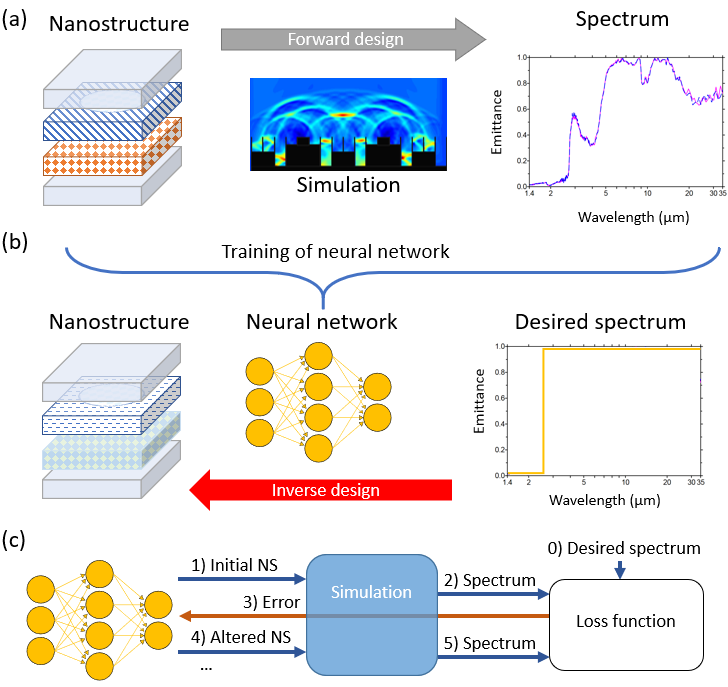

Figure 1: Overview of design processes. (a) Conventional forward design process. (b) Other inverse design process. Results from (a) are fed into the neural network that subsequently finds the geometry for the desired spectrum. (c) Inverse design process with backpropagation. The process is based on an iterative trial-and-error approach where the neural network inputs some initial nanostructure (NS) geometry to the simulation and gets feedback on how far from the desired spectrum it was.

#### Direct epsilon estimation (regression)

One approach NIDN takes to get to the desired property of the material is with direct estimation of the dielectric constant - called direct epsilon estimation or regression.
If you want to find, for instance, the dielectric constant for each layer or grid point in a structure such that the reflection, transmission, and absorption (RTA) satisfies your needs, then NIDN can give an estimate of the unbound dielectric constant for each frequency.

#### Utilizing real materials (classification)

The drawback with regression is that the dielectric constant for each frequency is not necessarily resembling that of a real material. To make the problem more realistic, NIDN can also classify which material has a dielectric constant for each frequency closest to the estimated one.

A problem with classification is that the selection of real materials can break the differentiability of the network. Currently, torch doesn't allow differentiability of the argmax function.
As a solution, we {Pablo fill in}.

To be able to classify materials, we must have a library of material properties available. For TRCWA, that means knowing the dielectric constant as a function of frequency of the light.
We are in the process of collecting more materials. If you know any good sources of materials over large spectra, feel free to let us know.

### Example 1 - Five uniform layers with unbound epsilon

Let's start with five uniform layers and see if NIDN can get sufficiently close to the desired spectra.

In [ ]:
cfg.Nx = 1 # Set layer size  to 1x1 (interpreted as uniform)
cfg.Ny = 1
cfg.N_layers = 5 # Choose number of layers
cfg.type = "regression" # Choose type as described above
cfg.iterations = 2000 # Set number of training iterations (that is forward model evaluations) to perform

In [ ]:
#Show all used settings
nidn.print_cfg(cfg)

`print_cfg(cfg)` shows you more or less everything you want to know about the config.
Using `run_training(cfg)`, we run the network until it reaches the number of iterations set above (or until you interrupt it using ctrl + c).

In [ ]:
nidn.run_training(cfg);

### Result interpretation
#### Loss plot
TODO Explain

In [ ]:
nidn.plot_losses(cfg)

#### Spectra plot
TODO Explain

In [ ]:
nidn.plot_spectra(cfg)

#### Absolute grid values plot
TODO Explain
TODO Explain layers

In [ ]:
nidn.plot_model_grid(cfg)

#### Epsilon vs frequency and real materials
TODO Explain

In [ ]:
nidn.plot_eps_per_point(cfg)

### Example 2 - 2 patterned layers with unbound epsilon

TODO

In [ ]:
cfg.pop("model",None); # Forget the old model
cfg.Nx = 16 # Set layer size  to 16x16 (each of the grid points has its own epsilon now)
cfg.Ny = 16
cfg.eps_oversampling = 4
cfg.N_layers = 2 # Less layer to keep compute managable
cfg.type = "regression" # Choose type as described above (for now still regression)
cfg.iterations = 250 # Set number of training iterations (that is forward model evaluations) to perform

In [ ]:
nidn.run_training(cfg);

In [ ]:
nidn.plot_losses(cfg)
nidn.plot_spectra(cfg)
nidn.plot_model_grid(cfg)
nidn.plot_eps_per_point(cfg)

### Example 3 - Patterned layer with bound epsilon

TODO

In [ ]:
cfg.pop("model",None); # Forget the old model
cfg.Nx = 16 # Set layer size  to 16x16 (each of the grid points has its own epsilon now)
cfg.Ny = 16
cfg.eps_oversampling = 8
cfg.N_layers = 2 # Less layer to keep compute managable
cfg.type = "classification" # Choose type as described above (for now still regression)
cfg.iterations = 250 # Set number of training iterations (that is forward model evaluations) to perform

In [ ]:
nidn.run_training(cfg);

#### Material ID plot
TODO

In [ ]:
nidn.plot_material_grid(cfg)

In [ ]:
# The other plots
nidn.plot_losses(cfg)
nidn.plot_spectra(cfg)
nidn.plot_model_grid(cfg)
nidn.plot_eps_per_point(cfg)

In [ ]:
# In case you want to save results you can use this handy function
# to save it to the results folder with a current timestamp
nidn.save_run(cfg)

# You can save all available plots to a single folder using this function
nidn.save_all_plots(cfg,save_path="/results/example/")